**Steps for Quantum Optimization Problem**

**Step 1: Encoding the Problem as a Cost Function**
- **Objective:** Transform the computational task into an optimization problem.
- **Method:** Define a cost function $C(\theta)$ such that the task is achieved when $C(\theta)$ is minimized.

**Step 2: Construct the Parameterized Quantum Circuit Ansatz**
- **Objective:** Create a quantum model to solve the target problem.
- **Method:** Construct the ansatz with parameters $\theta$. When $\theta$ is set to minimize the cost function, the ansatz becomes a quantum model for the problem.

**Step 3: Measure the Output Quantum State**
- **Objective:** Evaluate the performance of the quantum model.
- **Method:** Measure the output quantum state, obtain the measurement results, and calculate the cost function $C(\theta)$.

**Step 4: Update the Parameter $\theta$**
- **Objective:** Optimize the quantum model.
- **Method:** Use a classical parameter optimizer to update $\theta$ based on the cost function calculation.


# Variational Quantum Eigensolver (VQE)

## 1. What is it?

### My understanding

An algorithm used to find the ground state energy of a given Hamiltonian.

### [Given Definition](https://youtu.be/Z-A6G0WVI9w?feature=shared&t=127)

VQE is a hybrid algorithm, where the quantum part computes the energy, and the classical part optimizes the variational parameter.

![VQE](/home/zylu/Desktop/VQA/Screenshots/1.png)

### Hamiltonian

A Hamiltonian is just a mathematical description of the total energy of a system.

Operator corresponding to the total energy of a quantum system described by Heritian matrix

## 2. [How can we train it?](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)

In [1]:
!pip install pyscf
!pip install qiskit-aer
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install qiskit-ibm-runtime
!pip install pylatexenc
!pip install qiskit

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [5]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(
    channel='ibm_quantum',
    # instance='ibm-q/open/main',
    token='f2977527190eafdbadc695162a0868daebae442d431107df10a4e803ea9fd0cf6a11c0e584c18e276baa240734fbc57f664e0753bb0f34dcdba00ab7b4eb1400'

)


backend = service.least_busy(operational=True, simulator=False)

KeyboardInterrupt: 

### Step 1: Map classical inputs to a quantum problem

In [ ]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [ ]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [ ]:
num_params = ansatz.num_parameters
num_params

### Step 2: Optimize problem for quantum execution

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

In [ ]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

#### ISA observable

In [ ]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

Transform the Hamiltonian to make it backend-compatible before running jobs with 
Runtime Estimator V2 Perform the transformation by using the apply_layout method of SparsePauliOp object.

### Step 3: Execute using Qiskit Primitives


In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)

In [ ]:
x0

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

In [ ]:
res

### Step 4: Post-process, return result in classical format

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit

qiskit.version.get_version_info()

## 3. 𝜃

### the set of parameters that are used to define the unitary operations applied to the qubit register in the quantum circuit.

[The objective of the VQE is therefore to find a parameterization of |ψ⟩, such that the expectation value of the Hamiltonian is minimized.](https://arxiv.org/pdf/2111.05176)

## 4. Use Case

1. Electronic Structure Calculations: This is one of the most common applications of VQE, used to calculate the ground state energy and other electronic properties of molecules and materials. By optimizing the parameters of the wavefunction, VQE can efficiently approximate these problems on a quantum computer​(2111.05176v3)​.

2. Nuclear and High-Energy Physics: VQE is applied to problems in nuclear structure and high-energy physics, such as studying the interactions of nucleons and quarks, and solving the ground and excited states of these complex systems​(2111.05176v3)​.

3. Vibrational and Vibronic Spectroscopy: In chemistry and material science, VQE is used to predict the vibrational spectra and photochemical reaction properties of molecules, which are essential for understanding molecular structure and reaction mechanisms​(2111.05176v3)​.

4. Periodic Systems: VQE is also used to simulate solid-state and crystalline systems. By handling the Hamiltonians of these systems, VQE helps study the electronic structure and physical properties of materials​(2111.05176v3)​.

5. Nonlinear Schrödinger Equations: VQE can be used to solve nonlinear Schrödinger equations, which are important in various quantum mechanics problems​(2111.05176v3)​.

6. Quantum States of Black Holes and Cosmology: VQE has been used in advanced theoretical physics problems, such as computing quantum states of black holes and cosmological models​(2111.05176v3)​.

7. Extensions to Excited States: Although primarily used for ground state energy calculations, VQE can be extended to calculate excited states, which are crucial for understanding electronic excitation processes and optical properties of molecules​(2111.05176v3)​.

8. Hybrid and Embedding Methods: VQE can be combined with other classical computation methods to form hybrid computational frameworks. These methods break down problems into parts that can be solved on classical and quantum computers, expanding the applicability of VQE​

## 5. Citation

[Variational quantum eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)


[The Variational Quantum Eigensolver — Programming on Quantum Computers — Coding with Qiskit S2E4](https://youtu.be/Z-A6G0WVI9w?feature=shared)

# Quantum Approximate Optimization Algorithm (QAOA):

## What is it

[![QUBO](/home/zylu/Desktop/VQA/Screenshots/5.png)](https://link.springer.com/article/10.1007/s11128-024-04438-2)

QAOA is a hybrid iterative method for solving combinatorial optimization problems. 

One special case for finding approximate solutions for QUBO instances of the VQE

Idea: Encode cost function of optimization problem as problem Hamiltonian Hc

### [QUBO and MaxCut](https://youtu.be/YpLzSQPrgSc?feature=shared&t=446)

![QUBO](/home/zylu/Desktop/VQA/Screenshots/2.png)

## How can we train it

In [4]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [3]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

####  Step 1: Map classical inputs to a quantum problem


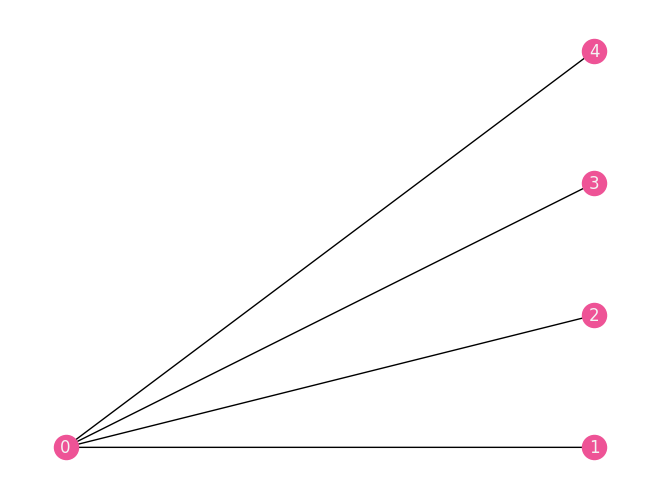

In [5]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

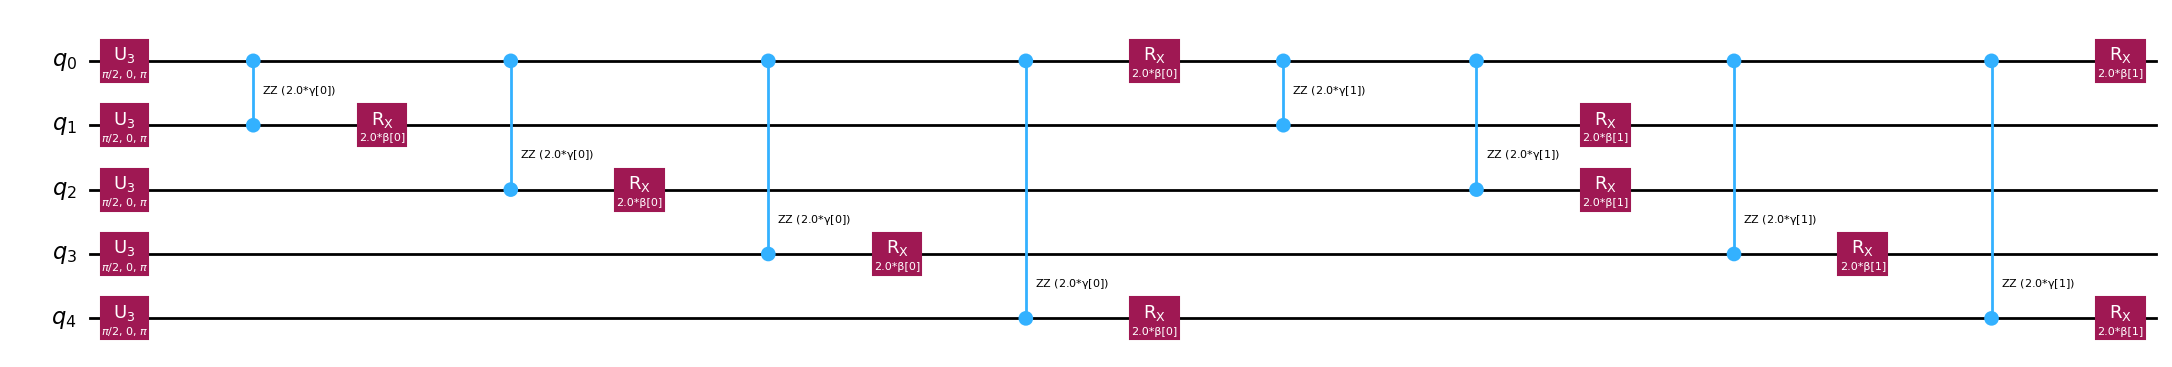

In [7]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp", fold=-1)

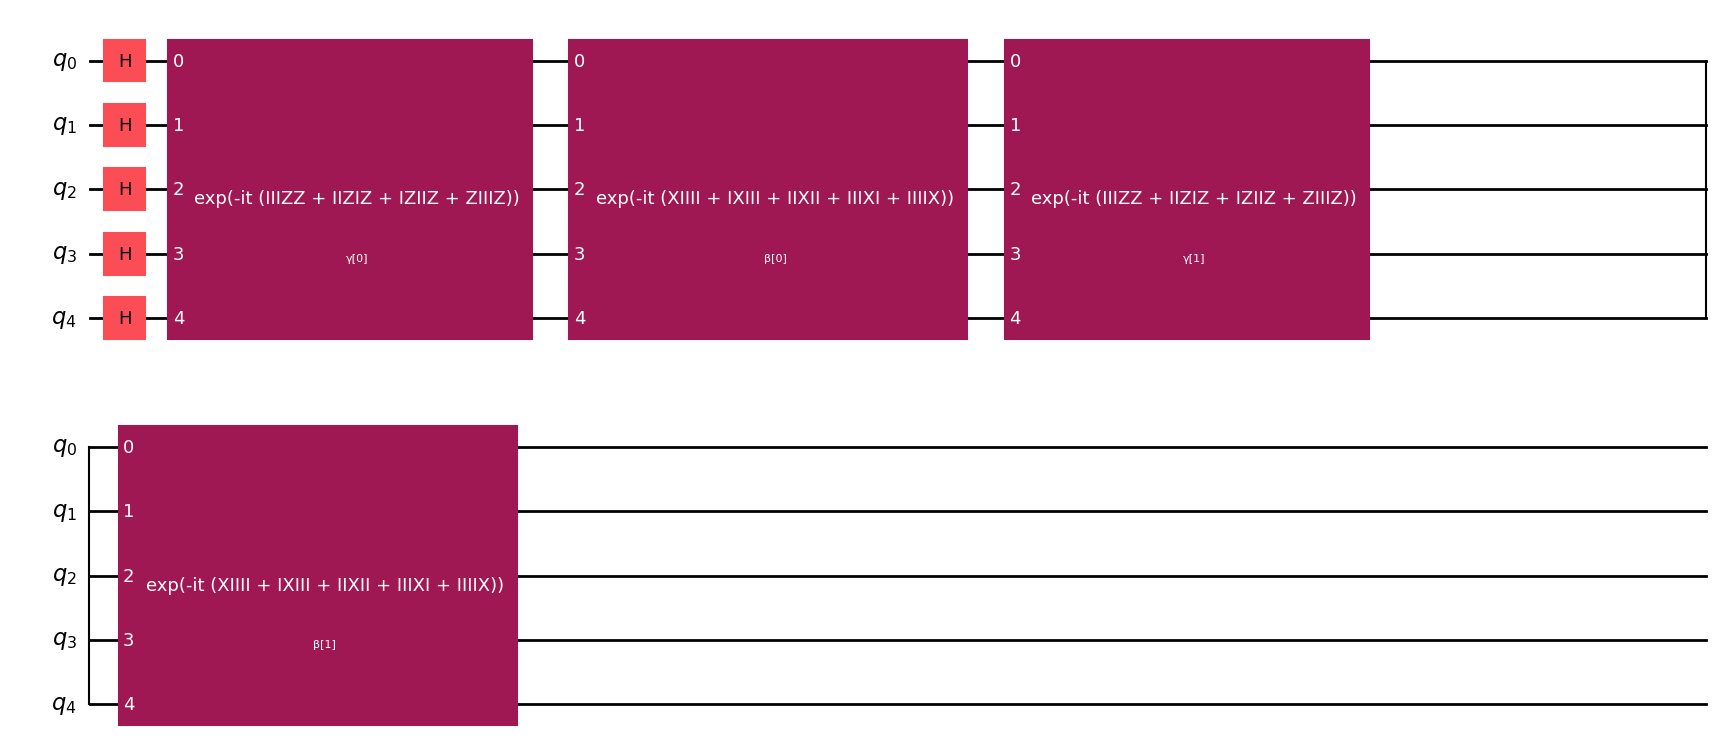

In [8]:
ansatz.decompose().draw(output="mpl", style="iqp")

### Step 2: Optimize problem for quantum execution.


In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

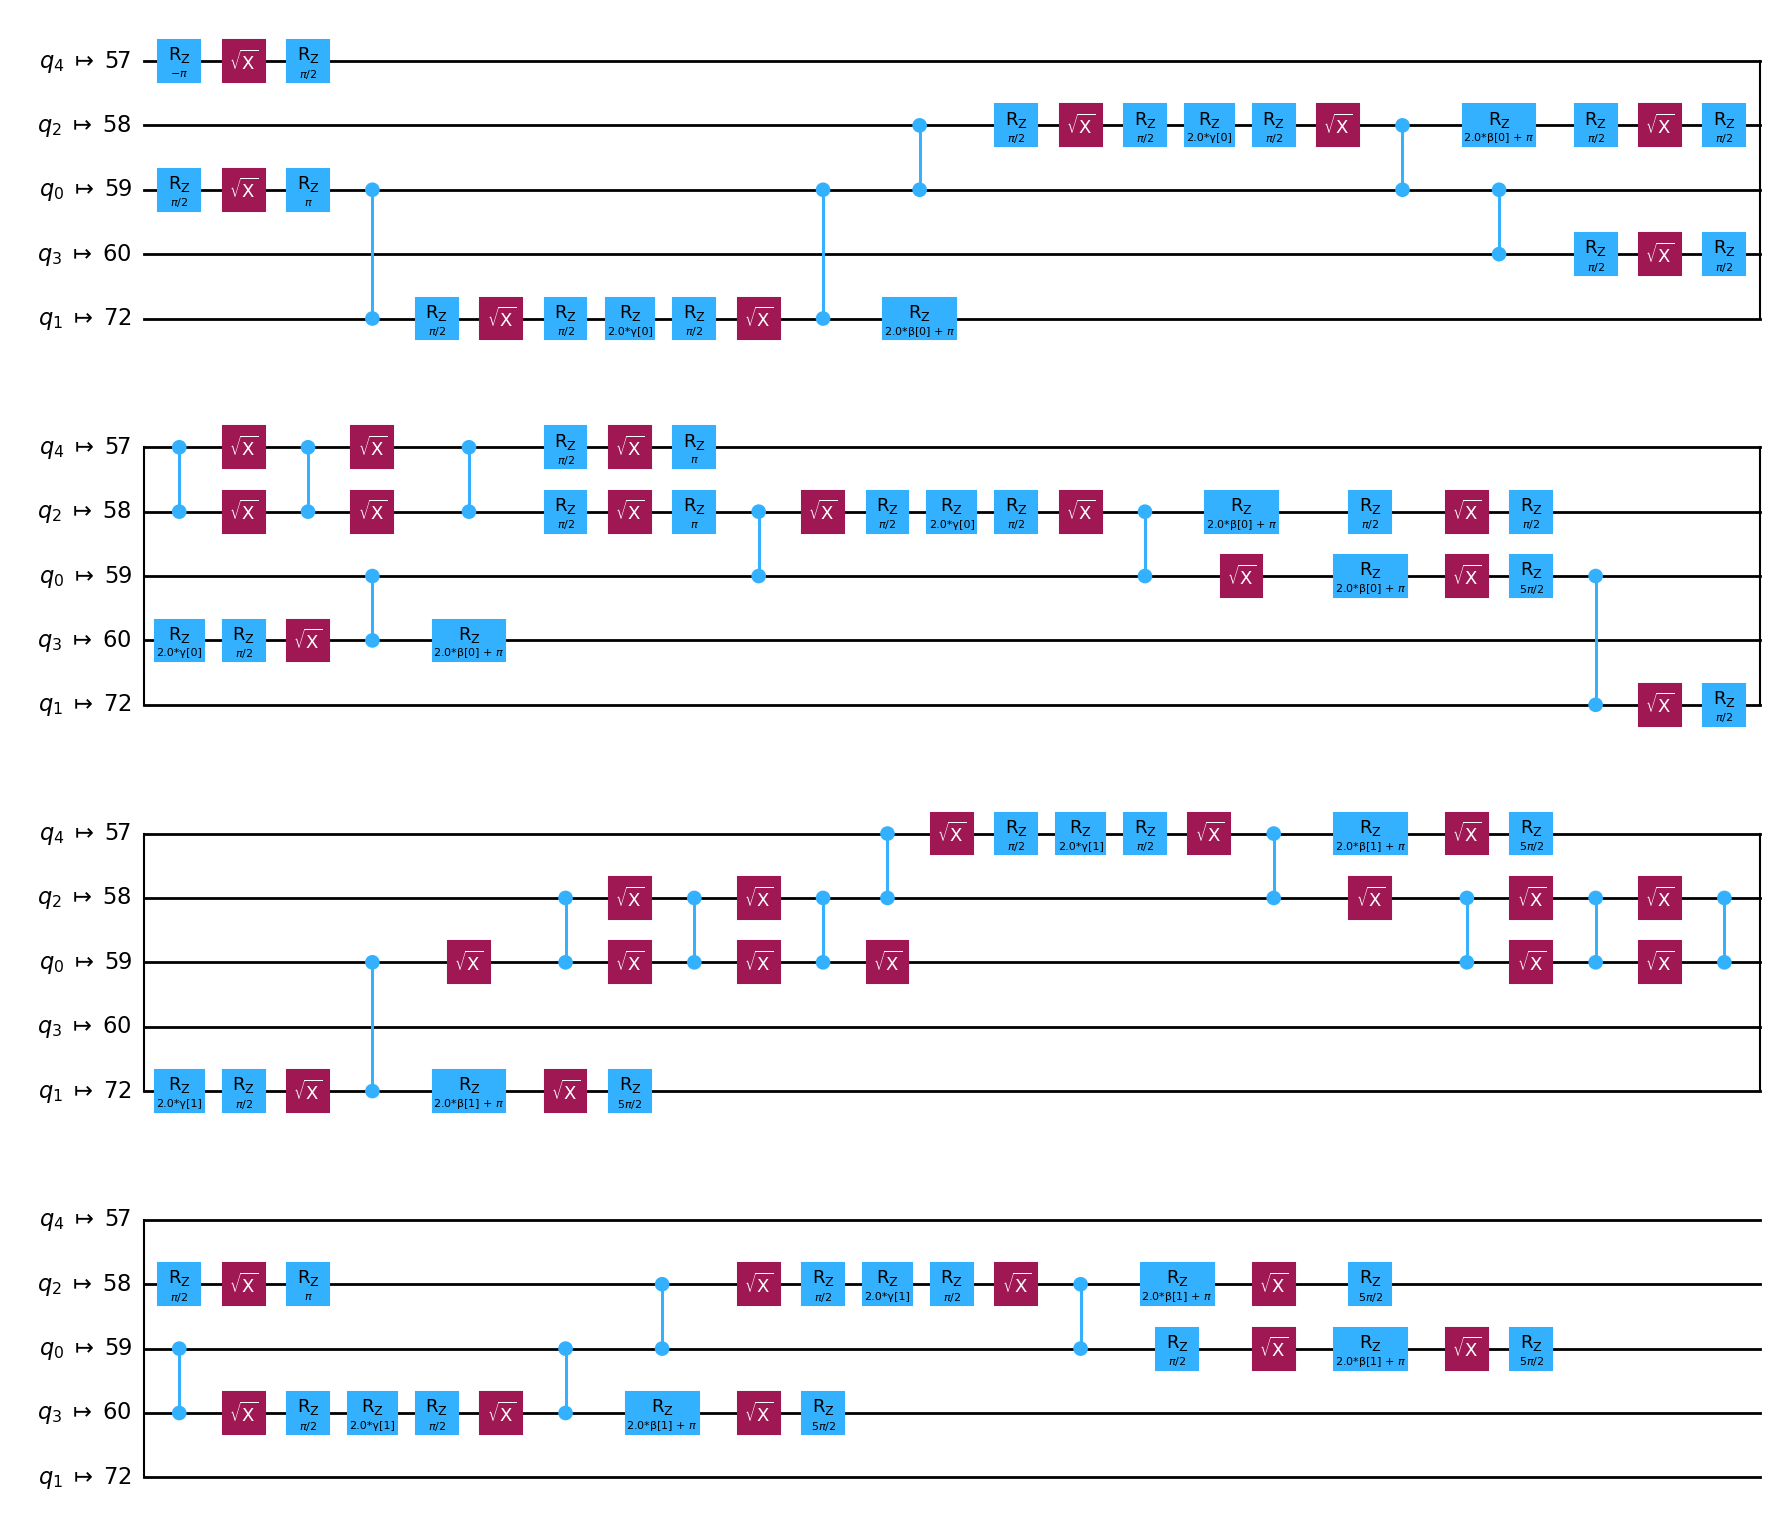

In [10]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

##### ISA Observables


In [11]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

### Step 3: Execute using Qiskit Primitives.


In [12]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [13]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(mode=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(mode=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

/tmp/ipykernel_460/2530742699.py:7: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)
/tmp/ipykernel_460/2530742699.py:12: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(session=session)


In [14]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [15]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

KeyboardInterrupt: 

In [ ]:
res

### Step 4: Post-process, return result in classical format.


In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

In [ ]:
plot_distribution(samp_dist, figsize=(15, 5))

In [ ]:
# Reverse 11110 to convert quantum result to classical solution
solution = [0, 1, 1, 1, 1]

mpl_draw(
    G,
    pos=rx.bipartite_layout(G, {0}),
    with_labels=True,
    node_color=["#EE5396" if kk else "#0F62FE" for kk in solution],
    font_color="#F4F4F4",
)

The most probable bit-strings, up to finite-sampling deviations, encode the solution. Here we see that 00001 and 11110 are found, and are indeed correct. There are two solutions because the labeling of the two partitions with '0' or '1' is arbitrary.

## Theta

[Theta Parameters (\(\theta\)) in QAOA](https://arxiv.org/abs/1411.4028)

 Definition
In the context of the Quantum Approximate Optimization Algorithm (QAOA), theta parameters consist of two sets of angles:
1.  **\($\gamma$) Parameters**: Angles associated with the application of the problem-specific Hamiltonian, which encodes the objective function of the optimization problem.
2. **($\beta$) Parameters**: Angles related to the application of the mixing Hamiltonian, which helps explore the solution space by promoting superposition.


## Ciation 

[Quantum approximate optimization algorithm from IBM](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)

[Introduction to the Quantum Approximate Optimization Algorithm and Applications](https://youtu.be/YpLzSQPrgSc?feature=shared)

[Intro to QAOA](https://pennylane.ai/qml/demos/tutorial_qaoa_intro/)

# Variational Quantum Metrology (VQM): Not really sure what it is!


## What is it

[a hybrid quantum-classical approach designed to enhance precision in quantum metrology, particularly for multiparameter estimation. It involves using a parameterized quantum circuit (ansatz) to prepare a trial state and a variational Positive Operator-Valued Measure (POVM) for measurements. The parameters of the quantum circuit are optimized using classical optimization techniques to maximize the information gained about the measured quantities, thereby improving estimation precision even in the presence of noise.)](https://www.nature.com/articles/s41598-023-44786-0)

Optimizes quantum sensors for multiparameter estimation.


## How can we train it

[tqix](https://github.com/echkon/tqix-developers) - an open-source software providing some convenient tools for quantum measurement, quantum metrology, quantum tomography, and others. In version 2.0.1 we add a library called tqix.pis for large-scale quantum simulation.

## 𝜃

Variational Quantum Metrology (VQM) utilizes variational principles to optimize quantum states and measurements for enhanced precision in parameter estimation. The theta parameters (θ) in VQM typically refer to the parameters of the quantum circuits and measurements that are being optimized. These parameters can be angles or coefficients within the quantum gates used to prepare the quantum state and perform the measurements.

[In VQM, these θ parameters are iteratively adjusted using a classical optimizer to minimize or maximize a cost function related to the quantum Fisher information, which quantifies the precision of the parameter estimation.](https://iopscience.iop.org/article/10.1088/1367-2630/ab965e)

# Variational Quantum Factoring (VQF):



## What is it

[Variational Quantum Factoring (VQF) is a hybrid quantum-classical algorithm designed to factor integers using near-term quantum devices. VQF reduces integer factoring to a combinatorial optimization problem solvable by the Quantum Approximate Optimization Algorithm (QAOA). It involves classical preprocessing to simplify the problem, mapping it to a Hamiltonian which the quantum processor optimizes to find the prime factors. VQF's success depends on the balance between quantum resources (qubits and circuit layers) and classical preprocessing, with performance influenced by noise and hardware limitations.](https://www.nature.com/articles/s41534-021-00478-z)



[![VQE](/home/zylu/Desktop/VQA/Screenshots/3.png)](https://www.nature.com/articles/s41534-021-00478-z)

## Theta

[The theta (θ) in the context of Variational Quantum Factoring (VQF) refers to the parameters of the quantum circuit used in the Quantum Approximate Optimization Algorithm (QAOA). These parameters are optimized during the VQF process to minimize the energy of the Hamiltonian that represents the factoring problem. The θ parameters essentially control the angles for the quantum gates in the QAOA circuit, guiding the quantum state evolution towards the solution of the factoring problem.](https://www.nature.com/articles/s41534-021-00478-z)



## How can we train it

[This repository]((https://github.com/mstechly/vqf)) contains implementation of the algorithm presented in the article "Variational Quantum Factoring", by Eric R. Anschuetz, Jonathan P. Olson, Alán Aspuru-Guzik, Yudong Cao. It's available on arxiv.

The notation in the code refers directly to the notation in the paper.

I gave a talk about this project, which might be a good introduction to it. You can find it on YouTube and the slides are in this repository in the presentation.pdf file.

Since QAOA is an important part of the algorithm, if you're unfamiliar with it you might find my blogpost about QAOA helpful.



# Quantum Semidefinite Programming (QSDP):



## What is it

[Quantum Semidefinite Programming (QSDP) is an extension of semidefinite programming (SDP) to the domain of quantum information theory. SDP is a subclass of convex optimization problems where one seeks to maximize (or minimize) a linear objective function subject to the constraint that an affine combination of symmetric matrices is positive semidefinite. In the quantum context, QSDP involves optimizing functions over matrices that represent quantum states or operations, making it a powerful tool for tasks like quantum state discrimination, entanglement detection, and quantum steering verification. It leverages efficient numerical methods to address complex quantum information problems.](https://iopscience.iop.org/article/10.1088/1361-6633/80/2/024001/meta)







## How can we train it

https://iopscience.iop.org/article/10.1088/1361-6633/80/2/024001/meta#ropaa4068app4

## Theta

the term "theta" typically refers to the complexity or bounds related to the performance of algorithms used in QSDP. Specifically, it can denote parameters like the rate of convergence, error bounds, or the efficiency of the optimization algorithms. The exact meaning of "theta" can vary depending on the specific problem being addressed and the algorithm being analyzed. [For detailed specifics, it's crucial to refer to the particular formulation or theorem within the QSDP framework.](https://arxiv.org/abs/2306.11637)

# Cascaded Variational Quantum Eigensolver (CVQE):



## what is it

https://pubs.acs.org/doi/full/10.1021/acsomega.4c01642

1. **Reduction in Quantum Circuit Executions**:
   - CVQE requires significantly fewer quantum circuit executions compared to VQE. This is crucial because executing quantum circuits is resource-intensive and time-consuming on current quantum hardware.

2. **Classical Postprocessing**:
   - Unlike VQE, which continuously updates parameters and executes quantum circuits throughout the optimization process, CVQE collects measurement samples from the quantum computer and processes them on a classical computer. This reduces the need for repeated quantum circuit executions during parameter optimization.

3. **Use of Jastrow Ansatz**:
   - CVQE leverages the Jastrow ansatz, which is a type of variational ansatz used in quantum chemistry to describe electron correlations. The Jastrow ansatz can efficiently represent many-body wavefunctions, which is beneficial for accurately capturing the properties of molecular systems.

4. **Handling of Two-Qubit Gate Errors**:
   - The postprocessing step in CVQE helps to mitigate errors associated with two-qubit gates (CNOT gates), which are a common source of error in quantum computations. This robustness against gate errors is a significant advantage over VQE.


**Advantages**

- **Efficiency**: By reducing the number of quantum circuit executions, CVQE is more resource-efficient, making it suitable for current noisy intermediate-scale quantum (NISQ) devices.
- **Accuracy**: The use of the Jastrow ansatz allows CVQE to accurately capture electron correlations in molecular systems, leading to precise energy calculations.
- **Robustness**: CVQE's classical postprocessing helps mitigate quantum hardware errors, improving the reliability of the results.


## How can we train it (https://pubs.acs.org/doi/full/10.1021/acsomega.4c01642) jump to methods section 

**Methodology**

1. **Initialization**:
   - The quantum system is initialized in a specific state, typically the Hartree-Fock state, where electrons occupy the lowest energy orbitals.

2. **Application of Thouless Operator**:
   - A unitary operator, known as the Thouless operator, is applied to the quantum state. This operator transforms the basis of the quantum state to facilitate efficient calculations.

3. **Measurement Collection**:
   - The quantum computer measures the transformed state, and these measurements are collected as samples for further processing.

4. **Classical Processing**:
   - The collected measurement samples are processed on a classical computer using a variational ansatz. The energy expectation value is calculated based on these measurements, and the variational parameters are optimized classically.

5. **Optimization**:
   - The optimization process iterates through different sets of variational parameters, adjusting them to minimize the energy expectation value. This step is performed on a classical computer, reducing the number of quantum circuit executions needed.


# Neural-Network-Encoded Variational Quantum Algorithms (NNVQA):



## What is it

Neural-Network-Encoded Variational Quantum Algorithms (NNVQAs) are a novel framework designed to improve the performance and efficiency of Variational Quantum Algorithms (VQAs) on noisy intermediate-scale quantum (NISQ) computers. The main idea behind NNVQAs is to leverage the strengths of both neural networks and parameterized quantum circuits to address some of the key challenges in implementing VQAs, such as the optimization difficulties and the high resource requirements.

**Key Features of NNVQAs**

1. **Neural Network Integration**:
   - NNVQAs use a neural network to encode the parameters of a given problem's Hamiltonian.
   - The neural network takes these Hamiltonian parameters as input and outputs the parameters for a quantum circuit (ansatz).

2. **Parameterized Quantum Circuits**:
   - The output from the neural network is used to parameterize a quantum circuit.
   - This circuit is then used in the standard VQA process to prepare quantum states and perform measurements.

3. **Training and Inference Separation**:
   - The NNVQA framework allows for a single pretraining process, after which the pretrained model can be used to handle a broad family of related problems.
   - This means that the model does not require retraining or fine-tuning for each new instance, significantly reducing the computational cost.

4. **Optimization and Training Efficiency**:
   - The use of a neural network can help in accelerating the optimization process by alleviating issues like barren plateaus and local minima.
   - An active learning strategy can be employed to further increase training efficiency while maintaining high prediction accuracy.

5. **Generalization and Scalability**:
   - NNVQAs demonstrate good generalization capabilities, being able to predict outcomes for Hamiltonians outside the training set with high precision.
   - The framework is scalable and can be applied to more complex quantum systems with multiple parameters.





## Theta

**Theta (θ) in Neural-Network-Encoded Variational Quantum Algorithms (NNVQAs)**

The `theta` (θ) in the context of Neural-Network-Encoded Variational Quantum Algorithms (NNVQAs) refers to the parameters of the quantum circuit (ansatz) that are used to represent the state of the quantum system. These parameters are generated by the neural network based on the input Hamiltonian parameters.

### Explanation of Theta in NNVQAs

1. **Hamiltonian Parameters (λ)**:
   - The problem is defined by a Hamiltonian \( \hat{H}(\lambda) \) where \( \lambda \) represents the parameters of the Hamiltonian.

2. **Neural Network Encoder**:
   - The neural network takes these Hamiltonian parameters \( \lambda \) as input and processes them to generate the parameters \( \theta \) for the quantum circuit.

3. **Parameterized Quantum Circuit (PQC)**:
   - The parameters \( \theta \) are used to parameterize a quantum circuit \( U(\theta) \). This circuit prepares the quantum state \( | \psi \rangle = U(\theta) | 0 \rangle \), where \( | 0 \rangle \) is the initial state of the quantum system.

4. **Cost Function and Optimization**:
   - The cost function for the variational quantum eigensolver (VQE) is the expectation value of the Hamiltonian \( \hat{H}(\lambda) \) with respect to the quantum state \( | \psi \rangle \):
     \[
     C(\phi) = \sum_i \langle \hat{H}(\lambda_i) \rangle = \sum_i \langle 0 | U^\dagger(\theta_i) \hat{H}(\lambda_i) U(\theta_i) | 0 \rangle
     \]
   - The neural network's parameters \( \phi \) are optimized using gradient-based methods to minimize this cost function, indirectly optimizing \( \theta \) for the quantum circuit.

### Role of Theta in NNVQAs

- **Generation**:
  - \( `theta` \) is generated by the neural network, \( $\theta = f_\phi(\lambda) $\), where \( f_phi) is the function represented by the neural network with weights \( \phi \)$.

- **Usage**:
  - \( `theta` \) parameterizes the quantum circuit which is then used to prepare the quantum state and perform the measurements needed for the VQA.

- **Optimization**:
  - During the training process, the neural network learns to produce the optimal \( \theta \) for different values of \( \lambda \), reducing the need for fine-tuning the quantum circuit for each specific problem instance.

By integrating a neural network to encode the parameters \( \theta \), NNVQAs aim to improve the efficiency and scalability of VQAs, enabling them to solve a broader range of quantum problems more effectively.


## How can we train

![VQE](/home/zylu/Desktop/VQA/Screenshots/4.png)

NOT sure about this

## **Application and Results**


The paper illustrates the NNVQA framework by applying it to a neural network variational quantum eigensolver (NNVQE) for solving the ground state of parameterized XXZ spin models in one and two dimensions. The results show that:

- NNVQAs can estimate ground-state energies with high precision without the need for fine-tuning.
- The overall training cost is significantly reduced.
- The framework can handle multiparameter Hamiltonians effectively.
- NNVQAs exhibit robustness to quantum noise, making them suitable for use with real NISQ devices.

# Quantum Classifier:



## What is it

[What is a variational quantum classifier?](https://medium.com/@typekrish/what-is-a-variational-quantum-classifier-888e40f83b24)

## How can we train

[Building a Quantum Variational Classifier Using Real-World Data](https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2)

## $\theta$

### Key Points about \($\theta$) in the VQC:

1. **Role in Quantum Circuits**:
    - In a quantum circuit, rotation gates such as \($R_x(\theta)$), \($R_y(\theta)$\), and \($R_z(\theta)$\) are used to manipulate the state of qubits. These gates rotate the qubit state around the respective axes (x, y, and z) of the Bloch sphere by an angle \(\theta\).

2. **Encoding and Classification**:
    - The VQC proposed in the paper involves encoding the input data into the quantum state using rotation gates. For example, if the input data is \((x_1, x_2)\), the encoding step might involve rotations \(R_z(x_1 \pi)\) and \(R_z(x_2 \pi)\).
    - After encoding, the circuit applies additional rotations parameterized by \(\theta\) and possibly entangling gates (like controlled-NOT or controlled-Z gates).

3. **Parameter Optimization**:
    - The \(\theta\) parameters are the key tunable elements of the quantum circuit. The performance of the VQC in classifying data depends on the values of these parameters.
    - A classical optimization algorithm is used to find the optimal values of \(\theta\). This is done by defining a cost function (such as a quadratic cost function) that measures how well the quantum classifier performs on the training data.
    - The optimization algorithm adjusts the \(\theta\) parameters iteratively to minimize the cost function, similar to how weights and biases are adjusted in classical neural networks during training.

4. **Hybrid Nature**:
    - The VQC operates in a hybrid fashion. The quantum part of the algorithm (the quantum circuit with rotation gates parameterized by \(\theta\)) generates outputs based on the current parameter values.
    - The classical part of the algorithm evaluates the outputs, calculates the cost, and updates the \(\theta\) parameters to improve the classifier's performance.


https://diposit.ub.edu/dspace/bitstream/2445/140318/1/GIL%20FUSTER%20Elies%20Miquel.pdf

![d](/home/zylu/Desktop/VQA/Screenshots/6.png)

## Use Case

[Hybrid framework for respiratory lung diseases detection based on classical CNN and quantum classifiers from chest X-rays](https://www.sciencedirect.com/science/article/pii/S1746809423010005)

# Quantum Neural Networks (QNNs):



## What is it

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html

## How can we train it

https://medium.com/@anjanakrishnan3100/qnn-a-beginners-overview-and-breakdown-of-code-d4f62a0947f2

## Theta


In the context of Quantum Neural Networks (QNNs), "theta" (θ) represents the parameters of the quantum circuit. These parameters are analogous to the weights in classical neural networks. They are adjustable values that the QNN optimizes during the training process to minimize a cost function, thereby learning the desired patterns from the data. The optimization of θ allows the QNN to improve its performance on specific tasks, leveraging quantum properties for potentially enhanced computational power.

# Quantum Support Vector Machines (QSVMs):



https://medium.com/mit-6-s089-intro-to-quantum-computing/quantum-support-vector-machine-qsvm-134eff6c9d3b

## Interesting paper on QSVMs

[The complexity of quantum support vector machines](https://quantum-journal.org/papers/q-2024-01-11-1225/)

[Quantum Support Vector Machine for Classifying Noisy Data](https://ieeexplore.ieee.org/abstract/document/10564586)